In [2]:
#import modules
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from scipy.stats import chi2
from scipy import odr
%matplotlib inline

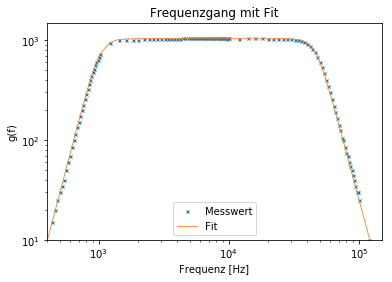

In [3]:
#load measured data
f, U_aus =np.loadtxt(r'C:\Users\Quirinus\Dropbox\Universe\Praktikum\PAP 2.2\243 - Thermisches Rauschen\Daten/Daten_thermischeRauschen.txt', skiprows=1, usecols=(0,1), unpack=True)

D=1e-3 #Dämpfungsglied
U_ein=0.2 #input voltage
g=U_aus/(U_ein*D) #Frequenzgang

#plot measured data
plt.loglog(f[17:-43],g[17:-43], linestyle='None', marker='x', markersize=3, label='Messwert')
plt.axis([4E2, 1.5e5, 10, 1.5E3])
plt.xlabel('Frequenz [Hz]')
plt.ylabel('g(f)')
plt.title('Frequenzgang')

#fit fit_func to measured data
def fit_func(f,V,W1,W2,n1,n2):
    return V/(np.sqrt(1+1/(f/W1)**(2*n1))*np.sqrt(1+(f/W2)**(2*n2)))
p0= [1000 , 1000 , 50000 , 5 , 5]
popt, pcov = curve_fit(fit_func, f[17:-43], g[17:-43] , p0, 0.03*g[17:-43])
perr = np.sqrt(np.diag(pcov))

#plot fitfunc
plt.loglog(f, fit_func(f, *popt), linewidth=0.8, label='Fit')
plt.axis([4E2, 1.5e5, 10, 1.5E3])
plt.xlabel('Frequenz [Hz]')
plt.ylabel('g(f)')
plt.title('Frequenzgang mit Fit')
plt.legend(loc='best')
plt.savefig(r'C:\Users\Quirinus\Dropbox\Universe\Praktikum\PAP 2.2\243 - Thermisches Rauschen\Diagramme\Frequnzgang.pdf' ,format='pdf')

In [4]:
def fit_func_square (f, V, W1, W2, n1, n2):
    return fit_func(f, V, W1, W2, n1, n2)**2
popt1=popt+perr
popt2=popt-perr
B=(integrate.quad(fit_func_square, f[10], f[-43], args=tuple(popt)))[0]
B_err = 0.02*B
print('Das Integral betraegt: %.2e +- %.1e' %(round(B, 2), round(B_err, 2)))

Das Integral betraegt: 4.99e+10 +- 1.0e+09


[ 0.00080688] +- [  1.55049419e-06]
Wahrscheinlichkeit=99.0%
0.626464512043
0.125292902409
Boltzmann konstante = (1.3648e-23 +- 2.6225e-26 stat. +- 2.7299e-25 syst.) J/K


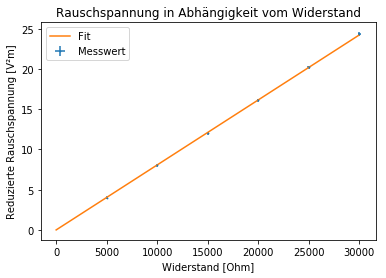

In [17]:
#measured data
R=np.array([30e3, 25e3, 20e3, 15e3, 10e3, 5e3]) #Resistance
R_err = 0.005*R #Resistance error
U_aus=np.array([5.1223, 4.7013, 4.245, 3.7326, 3.1496, 2.4355]) #output Voltage
err_U_aus=np.array([0.018, 0.016, 0.0168, 0.0157, 0.0129, 0.0121]) #output Voltage error
U_V=1.3812 #underground voltage
err_U_V=0.00709 #underground voltage error

D=U_aus**2-U_V**2
D_err=np.sqrt((2*U_aus*err_U_aus)**2+(2*U_V*err_U_V))

#theoretical function
def linear(c, x, *args):
    for i in args:
        return i*c
    return c*x


#model object and fit with x and y error
linear_model = odr.Model(linear)
data = odr.RealData(R, D, R_err, D_err)
func = odr.ODR(data, linear_model, [1])
out = func.run()

#fit parameters
popt = out.beta
perr = out.sd_beta
print(popt, '+-', perr)

#plot measured data and fit
plt.xlabel('Widerstand [Ohm]')
plt.ylabel('Reduzierte Rauschspannung [V²m]')
plt.title('Rauschspannung in Abhängigkeit vom Widerstand')
plt.errorbar(R, D, yerr=D_err, xerr = R_err, fmt='o', markersize = 0.8, label='Messwert')
x_plot = np.linspace(0, R[0])
plt.plot(x_plot, linear(*popt, x_plot), label = 'Fit')
plt.legend()
plt.savefig(r'C:\Users\Quirinus\Dropbox\Universe\Praktikum\PAP 2.2\243 - Thermisches Rauschen\Diagramme\Rauschspannung.pdf' ,format='pdf')

#Bolzmann constant
T = 23.3+273.15
T_err = 0.1
k = popt[0]/(T*B*4)*1e-6
k_err_syst = k*np.sqrt((T_err/T)**2+(B_err/B)**2)
k_err_stat = k*perr[0]/popt[0]

chisquare=np.sum(((linear(R,*popt)-D)**2/D_err**2))
dof=5
chisquare_red=chisquare/dof
prob=round(1-chi2.cdf(chisquare,dof),2)*100

print("Wahrscheinlichkeit="+str(prob)+"%")
print(chisquare)
print(chisquare_red)
print('Boltzmann konstante = (%.4e +- %.4e stat. +- %.4e syst.) J/K' %(k, k_err_stat, k_err_syst))